In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn

from multiprocessing import Pool


sys.path.append("../functions")

from Utils import *
from Plotting import *
from Forward import *
from Backward import *

In [2]:
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "hc")
subjects = lv_induction_data["sub"].unique()

In [3]:
def add_noise_to_conf(confs, scale):
    confs_cloned = confs.copy()
    noises =  np.random.normal(loc=0.0, scale=scale, size= len(confs))
    confs_cloned += noises
    confs_cloned[confs_cloned > 5] = 5
    confs_cloned[confs_cloned <1] = 1
    return confs_cloned

In [ ]:
from Forward import simulate_agent

noise_stds = [0,1,2,4]
alpha_array = np.linspace(.05, 1, 10)
betas = [5, 15, 40]
mrls = np.zeros((len(alpha_array), len(betas), len(subjects),len(noise_stds)))
backward_perfs = np.zeros_like(mrls)
forward_perfs = np.zeros_like(mrls)
backward_dists = np.zeros_like(mrls)

lbound = 1
hbound = 5
n_fitting = 1
params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]

for i, alpha in enumerate(alpha_array):
    print("i = {}".format(i))
    for j, beta in enumerate(betas):
        print("j = {}".format(j))
        params = [alpha, beta, lbound, hbound]
        for s, sub in enumerate(subjects):
            trials_info = get_subject_task(lv_induction_data, sub)
            resps, rewards, acc, confs, Q_list = simulate_agent(params, trials_info)
            
            input_dict = {"resp": resps, "reward": rewards, "cj": confs, "n_fitting": n_fitting, "params_ranges": params_ranges, "scale": True}

            forward_params, forward_neg_LL, forward_dist = forward_fitting(input_dict)
            forward_params_df = pd.DataFrame({"subject": [sub], "alpha" : [forward_params[0]], "beta" : [forward_params[1]], 
                                                "lbound" : [forward_params[2]], "hbound": 5})
            
            forward_sim = simulate_with_params(forward_params_df, lv_induction_data, subjects,1)
            forward_perf = forward_sim["cor"].mean()
            
            forward_perfs[i, j, s,:] = forward_perf
            for n, noise in enumerate(noise_stds):
                if noise != 0:
                    noisy_confs = add_noise_to_conf(confs, noise)
                else: 
                    noisy_confs = confs.copy()
                    
                input_dict["cj"] = noisy_confs
                
                backward_params, backward_neg_LL, backward_dist = fit_model_backward(input_dict)
    
                backward_params_df = pd.DataFrame({"subject": [sub], "alpha" : [backward_params[0]], "beta" : [backward_params[1]], 
                                                  "lbound" : [backward_params[2]], "hbound": 5})

                backward_sim = simulate_with_params(backward_params_df, lv_induction_data, subjects,1)
                backward_perf = backward_sim["cor"].mean()
                
                backward_perfs[i, j, s, n] = backward_perf
                mrls[i, j, s, n] = backward_perf/forward_perf
                backward_dists[i, j, s, n] = backward_dist
                
np.savez('../results/mrl_noisy', mrls=mrls, backward_perfs=backward_perfs, forward_perfs= forward_perfs, backward_dists = backward_dists)

In [5]:
# load computed results 
alpha_res = np.load("../results/mrl_noisy_alpha.npz")

In [6]:
!cp ../../meta-meassure/results/learning_aspects_beta.npz ../results/

/tmp/ipykernel_17345/2078304508.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_df["beta"] = alpha_df["beta"].astype(int)
/tmp/ipykernel_17345/2078304508.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_df["beta"] = alpha_df["beta"].astype(int)
/tmp/ipykernel_17345/2078304508.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

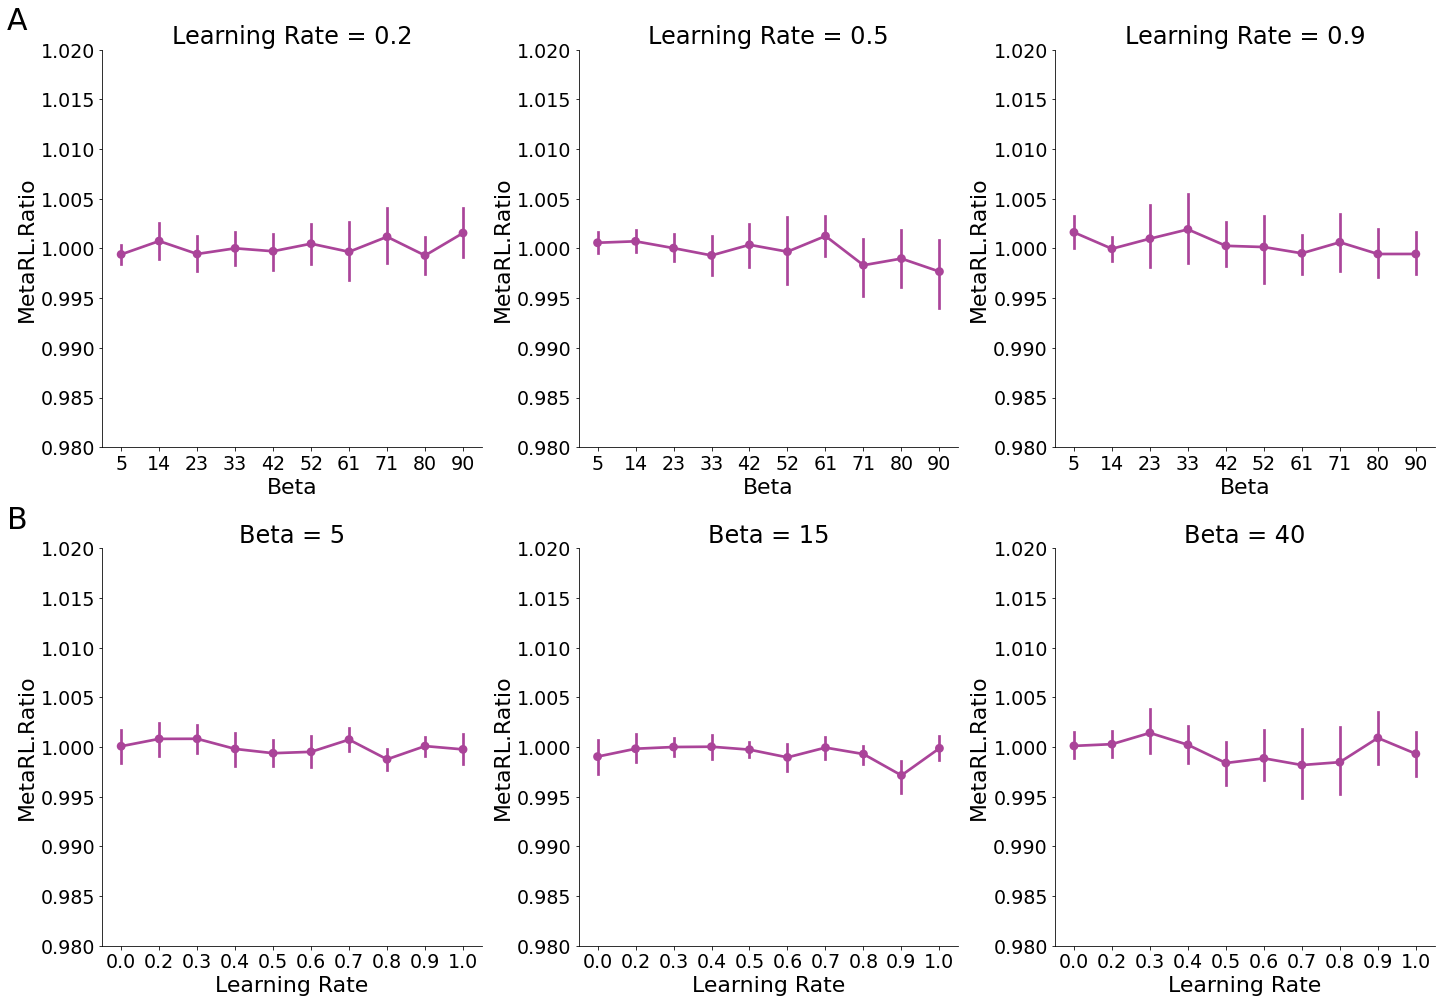

In [8]:
plt.subplots(figsize=(20, 14))

from matplotlib.ticker import FormatStrFormatter

noise_stds = [0,1,2,4]


beta_res = np.load("../results/mrl_noisy_beta.npz")
mrls = beta_res["mrls"]
alpha_array = [.2, .5, .9]
betas = np.linspace(5, 90, 10)
alpha_ls = []
beta_ls = []
subject_ls = []
noise_ls = []
mrls_ls = []
for i in range(len(alpha_array)):
    for j in range(len(betas)):
        for l in range(len(subjects)):
            for m in range(len(noise_stds)):
                alpha_ls.append(alpha_array[i])
                beta_ls.append(betas[j])
                subject_ls.append(subjects[l])
                noise_ls.append(noise_stds[m])
                mrls_ls.append(mrls[i,j,l,m])

beta_agg_df = pd.DataFrame(zip(alpha_ls, beta_ls, subject_ls, noise_ls, mrls_ls), columns=["alpha", "beta", "subject", "Noise-SD", "mrl"])


for i in range(len(alpha_array)):
    plt.subplot(2, 3, i+1)
    if i == 0:
        plt.text(-3, 1.022, "A", fontsize=30)
    alpha_df = beta_agg_df[beta_agg_df["alpha"] == alpha_array[i]]
    alpha_df["beta"] = alpha_df["beta"].astype(int)
    clrs = ["#2C041C", "#8F00FF", "#DA70D6", "#D8BFD8"]
    # for noise, clr in zip(noise_stds, clrs):
    #     beta_df_nois= beta_df[beta_df["noise"] == noise]
    #     seaborn.pointplot(beta_df_nois, x = "alpha", y = "mrl", color= clr)
    
    
    alpha_0 = alpha_df[alpha_df["Noise-SD"] == 0]
    seaborn.pointplot(alpha_0, x = "beta", y = "mrl", color = "#AA4499")

    plt.title("Learning Rate = {}".format(alpha_array[i]), fontsize=24)
    plt.xlabel("Beta", fontsize=22)
    plt.ylabel("MetaRL.Ratio", fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=19)
    ax = plt.gca()
    plt.ylim([.98, 1.02])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
alpha_res = np.load("../results/mrl_noisy_alpha.npz")

mrls = alpha_res["mrls"]
alpha_array = np.linspace(.05, 1, 10)
betas = [5, 15, 40]
alpha_ls = []
beta_ls = []
subject_ls = []
noise_ls = []
mrls_ls = []
for i in range(len(alpha_array)):
    for j in range(len(betas)):
        for l in range(len(subjects)):
            for m in range(len(noise_stds)):
                alpha_ls.append(alpha_array[i])
                beta_ls.append(betas[j])
                subject_ls.append(subjects[l])
                noise_ls.append(noise_stds[m])
                mrls_ls.append(mrls[i,j,l,m])

lr_agg_df = pd.DataFrame(zip(alpha_ls, beta_ls, subject_ls, noise_ls, mrls_ls), columns=["alpha", "beta", "subject", "Noise-SD", "mrl"])

betas = [5, 15, 40]
for i in range(len(betas)):
    plt.subplot(2, 3, i+4)
    if i == 0:
        plt.text(-3, 1.022, "B", fontsize=30)
    beta_df = lr_agg_df[lr_agg_df["beta"] == betas[i]]
    beta_df["alpha"] = beta_df["alpha"].round(1)
    clrs = ["#2C041C", "#8F00FF", "#DA70D6", "#D8BFD8"]
    # for noise, clr in zip(noise_stds, clrs):
    #     beta_df_nois= beta_df[beta_df["noise"] == noise]
    #     seaborn.pointplot(beta_df_nois, x = "alpha", y = "mrl", color= clr)
    beta_0 = beta_df[beta_df["Noise-SD"] == 0]

    seaborn.pointplot(beta_0, x = "alpha", y = "mrl", color= "#AA4499")

    plt.title("Beta = {}".format(betas[i]), fontsize=24)
    plt.xlabel("Learning Rate", fontsize=22)
    plt.ylabel("MetaRL.Ratio", fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=19)
    plt.ylim([.98, 1.02])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/supp_fig7.png", bbox_inches = "tight")

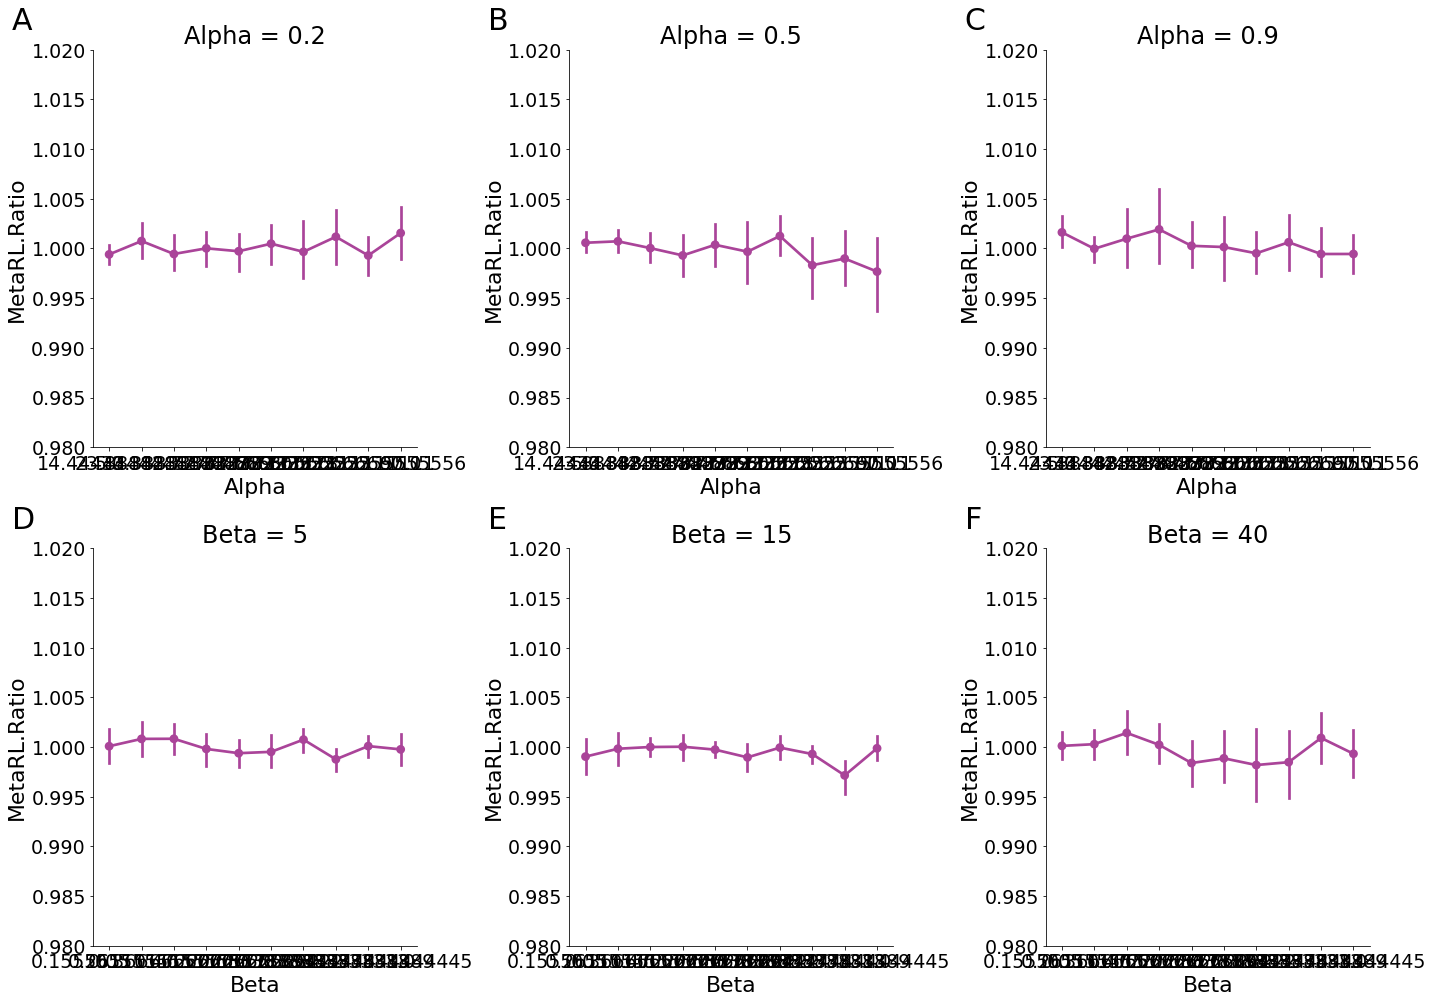

In [10]:

def prepare_aggregated_df(mrls, alpha_array, betas, subjects, noise_stds):
    """Aggregates MRL data into a DataFrame."""
    alpha_ls, beta_ls, subject_ls, noise_ls, mrls_ls = [], [], [], [], []
    for i, alpha in enumerate(alpha_array):
        for j, beta in enumerate(betas):
            for l, sub in enumerate(subjects):
                for m, noise in enumerate(noise_stds):
                    alpha_ls.append(alpha)
                    beta_ls.append(beta)
                    subject_ls.append(sub)
                    noise_ls.append(noise)
                    mrls_ls.append(mrls[i, j, l, m])
    return pd.DataFrame({"alpha": alpha_ls, "beta": beta_ls, "subject": subject_ls,
                         "Noise-SD": noise_ls, "mrl": mrls_ls})

def plot_mrl_subplot(df, param, fixed_value, subplot_idx, letter, clr="#AA4499", round_alpha=2):
    """Plots MetaRL ratio for a given parameter, with rounding applied to alpha."""
    ax = plt.subplot(2, 3, subplot_idx)
    plt.text(-3, 1.022, letter, fontsize=30)
    
    # Apply rounding as necessary
    if param == 'alpha':
        df[param] = df[param].round(round_alpha)
        fixed_value = round(fixed_value, round_alpha)
        df_param = df[df[param] == fixed_value]
        x, y = "beta", "mrl"
    else:
        df_param = df[df[param].astype(int) == fixed_value]
        x, y = "alpha", "mrl"
    
    df_param = df_param[df_param["Noise-SD"] == 0]
    sns.pointplot(data=df_param, x=x, y=y, color=clr, ax=ax)
    plt.title(f"{param.capitalize()} = {fixed_value}", fontsize=24)
    plt.xlabel(param.capitalize(), fontsize=22)
    plt.ylabel("MetaRL.Ratio", fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=19)
    plt.ylim([.98, 1.02])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots(figsize=(20, 14))

# Load results and prepare DataFrames
beta_res = np.load("../results/mrl_noisy_beta.npz")
mrls = beta_res["mrls"]
beta_agg_df = prepare_aggregated_df(mrls, [.2, .5, .9], np.linspace(5, 90, 10), subjects, noise_stds)

alpha_res = np.load("../results/mrl_noisy_alpha.npz")
mrls = alpha_res["mrls"]
lr_agg_df = prepare_aggregated_df(mrls, np.linspace(.05, 1, 10), [5, 15, 40], subjects, noise_stds)

# Plot subplots for Beta analysis
for i, alpha in enumerate([.2, .5, .9]):
    plot_mrl_subplot(beta_agg_df, 'alpha', alpha, i+1, chr(65+i))

# Plot subplots for Alpha analysis
for i, beta in enumerate([5, 15, 40]):
    plot_mrl_subplot(lr_agg_df, 'beta', beta, i+4, chr(68+i))

plt.tight_layout()
plt.savefig("../figs/supp_fig7.png", bbox_inches="tight")
plt.show()
